# Homework 1  
## Smoke detector can save people's life. The [US National Fire Protection Association reports](https://www.nfpa.org/News-and-Research/Data-research-and-tools/Detection-and-Signaling/Smoke-Alarms-in-US-Home-Fires) 0.53 deaths per 100 fires in homes with working smoke detectors compared to 1.18 deaths without (2009–2013). Smoke detector senses many different materials in the air for it to make decision. Therefore, there is a chance that it makes false alarm. A major problem is to make the smoke detector more reliable. In this case, logistic regression can be used to predict the likelihood of a fire alarm respect to many different variables. This [dataset](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset) contains whether a fire alarm was triggered and corresponding detailed data read from IoT devices with many different environments and fire sources.

## Navigation
* [1. Import librarys and data](#section1)
* [2. Initial analysis for data cleaning purpose](#section2)
  - [Initial analysis result](#section21)
  - [Feature Description](#section22)
* [3. Data cleaning](#section3)
* [4. EDA](#section4)
  - [Count number of different outcomes](#section41)
  - [Analyze mean, STD, etc](#section42)
  - [Analyze heat map and correlations](#section43)
  - [Conclusion](#section44)
* [5. Data Preprocess](#section5)
  - [Split dataset](#section51)
* [6. Model](#section6)
  - [Implementation](#section61)
  - [Prediction](#section62)
    - [Batch Gradient Descent](#section621)
    - [Stochastic Gradient Descent](#section622)
    - [Batch Gradient Descent with momentum](#section623)
    - [Batch Gradient Descent with Adam](#section624)
* [7. Analyze Result](#section7)
  - [Visualizations](#section71)
    - [Loss Visualizations](#section711)
    - [Metrics Comparison Visualization](#section712)
  - [Conclusion](#section72)

<a id="section1"></a>
## Import librarys and data

In [1]:
import os
import pdb
import time
import torch
import random

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from os import listdir
from os.path import join, exists

from sklearn import metrics
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data_path = "./smoke_detection_iot.csv"
df = pd.read_csv(data_path)

<a id="section2"></a>
## Initial analysis for cleaning purpose

In [3]:
# Check data info
print(f"\033[1mData shape: \n{df.shape}\n")
print(f"Count null: \n{df.isnull().sum()}\n")
print(f"Unique values: \n {df.nunique()}\n")
df.info()
df.head()

Data shape: 
(62630, 16)

Count null: 
Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

Unique values: 
 Unnamed: 0        62630
UTC               62630
Temperature[C]    21672
Humidity[%]        3890
TVOC[ppb]          1966
eCO2[ppm]          1713
Raw H2             1830
Raw Ethanol        2659
Pressure[hPa]      2213
PM1.0              1337
PM2.5              1351
NC0.5              3093
NC1.0              4113
NC2.5              1161
CNT               24994
Fire Alarm            2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed:

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


<a id="section21"></a>
### Initial analysis result
#### The data has no missing value. The dtype of all the columns' values are either int or float so I don't need to do any converting. Then, I decide to drop column "Unnamed: 0", "CNT", and "UTC" since the values in these three columns are all unique and have no help for predicting the output.  

<a id="section22"></a>
### Feature Description  
#### UTC: Timestamp UTC seconds.  
#### Temperature: Air temperature.  
#### Humidity: Air humidity.  
#### TVOC: Total Volatile Organic Compounds; measured in parts per billion.  
#### eCo2: CO2 equivalent concentration; calculated from different values like TVCO.  
#### Raw H2: Raw molecular hydrogen; not compensated (Bias, temperature, etc.).  
#### Raw Ethanol: Raw ethanol gas.  
#### Pressure: Air pressure.  
#### PM1.0: Particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5).  
#### PM2.5: Particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5).  
#### NC0.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5).  
#### NC1.0: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5).  
#### NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5).  
#### CNT: Sample counter.  
#### Fire Alarm: ground truth is "1" if a fire is there.

<a id="section3"></a>
## Data cleaning  
### In this step, I will drop three columns ("Unnamed: 0", "CNT", and "UTC") and resulting a cleaned dataset with 62630 rows and 13 columns.

In [4]:
# Drop useless columns and check data info again
df = df.drop(columns=["Unnamed: 0", "UTC", "CNT"])
print(f"\033[1mData shape: \n{df.shape}\n")
print(f"Count null: \n{df.isnull().sum()}\n")
print(f"Unique values: \n {df.nunique()}\n")
df.info()
df.head()

Data shape: 
(62630, 13)

Count null: 
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
Fire Alarm        0
dtype: int64

Unique values: 
 Temperature[C]    21672
Humidity[%]        3890
TVOC[ppb]          1966
eCO2[ppm]          1713
Raw H2             1830
Raw Ethanol        2659
Pressure[hPa]      2213
PM1.0              1337
PM2.5              1351
NC0.5              3093
NC1.0              4113
NC2.5              1161
Fire Alarm            2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  int64  
 3   eCO2[

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


<a id="section4"></a>
## EDA

<a id='section41'></a>
### Count number of different outcomes

In [5]:
df['Fire Alarm'].value_counts()

1    44757
0    17873
Name: Fire Alarm, dtype: int64

<AxesSubplot:xlabel='Fire Alarm', ylabel='Count'>

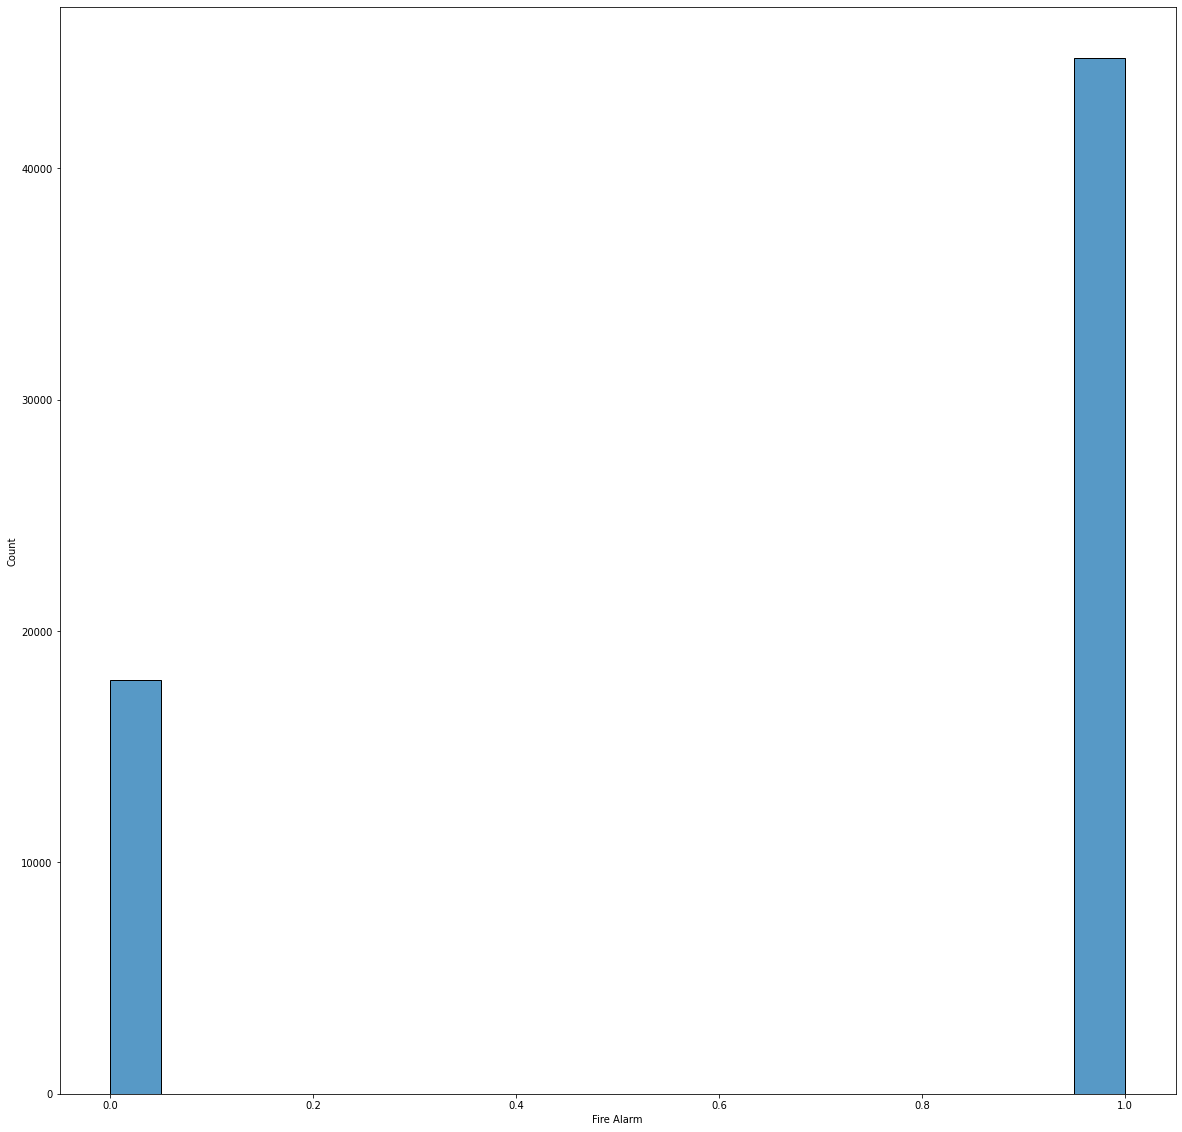

In [6]:
plt.figure(figsize=(20, 20))
sns.histplot(df['Fire Alarm'])

<a id='section42'></a>
### Analyze mean, STD, etc

In [7]:
df.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Raw Ethanol,62630.0,19754.257912,609.513156,15317.000,19435.00000,19501.000,20078.0000,21410.000
Raw H2,62630.0,12942.453936,272.464305,10668.000,12830.00000,12924.000,13109.0000,13803.000
TVOC[ppb],62630.0,1942.057528,7811.589055,0.000,130.00000,981.000,1189.0000,60000.000
Pressure[hPa],62630.0,938.627649,1.331344,930.852,938.70000,938.816,939.4180,939.861
eCO2[ppm],62630.0,670.021044,1905.885439,400.000,400.00000,400.000,438.0000,60000.000
NC0.5,62630.0,491.463608,4265.661251,0.000,8.82000,12.450,14.4200,61482.030
NC1.0,62630.0,203.586487,2214.738556,0.000,1.38400,1.943,2.2490,51914.680
PM2.5,62630.0,184.467770,1976.305615,0.000,1.34000,1.880,2.1800,45432.260
PM1.0,62630.0,100.594309,922.524245,0.000,1.28000,1.810,2.0900,14333.690
NC2.5,62630.0,80.049042,1083.383189,0.000,0.03300,0.044,0.0510,30026.438


In [8]:
df.groupby('Fire Alarm')[df.keys().drop('Fire Alarm')].mean()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,19.694803,42.930077,4596.587255,962.587255,12896.316847,20082.823533,938.101383,261.982706,450.034639,1356.283816,493.872027,178.982259
1,14.483152,50.779534,882.013071,553.189356,12960.878053,19623.050428,938.837806,36.146406,78.417842,146.111337,87.665549,40.541627


In [9]:
df.describe().T.sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TVOC[ppb],62630.0,1942.057528,7811.589055,0.000,130.00000,981.000,1189.0000,60000.000
NC0.5,62630.0,491.463608,4265.661251,0.000,8.82000,12.450,14.4200,61482.030
NC1.0,62630.0,203.586487,2214.738556,0.000,1.38400,1.943,2.2490,51914.680
PM2.5,62630.0,184.467770,1976.305615,0.000,1.34000,1.880,2.1800,45432.260
eCO2[ppm],62630.0,670.021044,1905.885439,400.000,400.00000,400.000,438.0000,60000.000
NC2.5,62630.0,80.049042,1083.383189,0.000,0.03300,0.044,0.0510,30026.438
PM1.0,62630.0,100.594309,922.524245,0.000,1.28000,1.810,2.0900,14333.690
Raw Ethanol,62630.0,19754.257912,609.513156,15317.000,19435.00000,19501.000,20078.0000,21410.000
Raw H2,62630.0,12942.453936,272.464305,10668.000,12830.00000,12924.000,13109.0000,13803.000
Temperature[C],62630.0,15.970424,14.359576,-22.010,10.99425,20.130,25.4095,59.930


In [10]:
df.groupby('Fire Alarm')[df.keys().drop('Fire Alarm')].std()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,14.982932,11.962854,14255.575585,2921.749928,432.441620,956.339624,1.237957,1439.725596,2828.774776,7155.122661,3150.390163,1446.595793
1,13.825585,5.937239,548.606072,1275.260976,167.385665,307.123385,1.309030,590.458583,1493.576072,2144.942045,1689.242658,895.171419


In [11]:
df.median().sort_values(ascending=False)

Raw Ethanol       19501.000
Raw H2            12924.000
TVOC[ppb]           981.000
Pressure[hPa]       938.816
eCO2[ppm]           400.000
Humidity[%]          50.150
Temperature[C]       20.130
NC0.5                12.450
NC1.0                 1.943
PM2.5                 1.880
PM1.0                 1.810
Fire Alarm            1.000
NC2.5                 0.044
dtype: float64

In [12]:
df.groupby('Fire Alarm')[df.keys().drop('Fire Alarm')].median()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,20.54,46.14,86.0,400.0,12837.0,20158.0,937.478,1.45,1.52,9.97,1.578,0.039
1,20.02,51.40,1103.0,404.0,12933.0,19454.0,938.878,1.87,1.94,12.86,2.005,0.045


<a id='section43'></a>
### Analyze heat map and correlations

<AxesSubplot:>

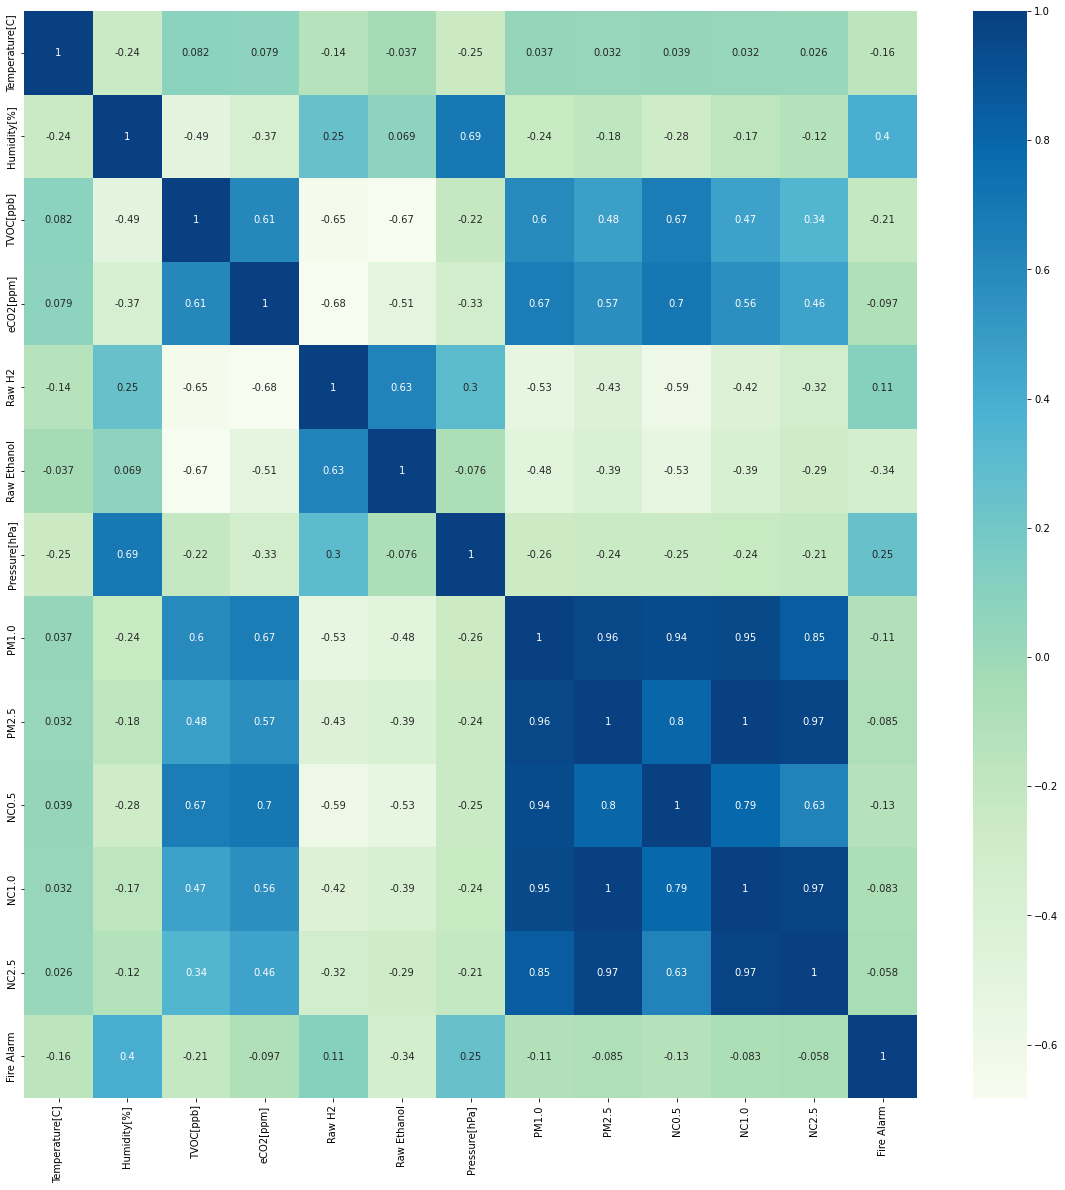

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='GnBu')

<AxesSubplot:title={'center':'Correlation coefficient between features and Fire Alarm'}>

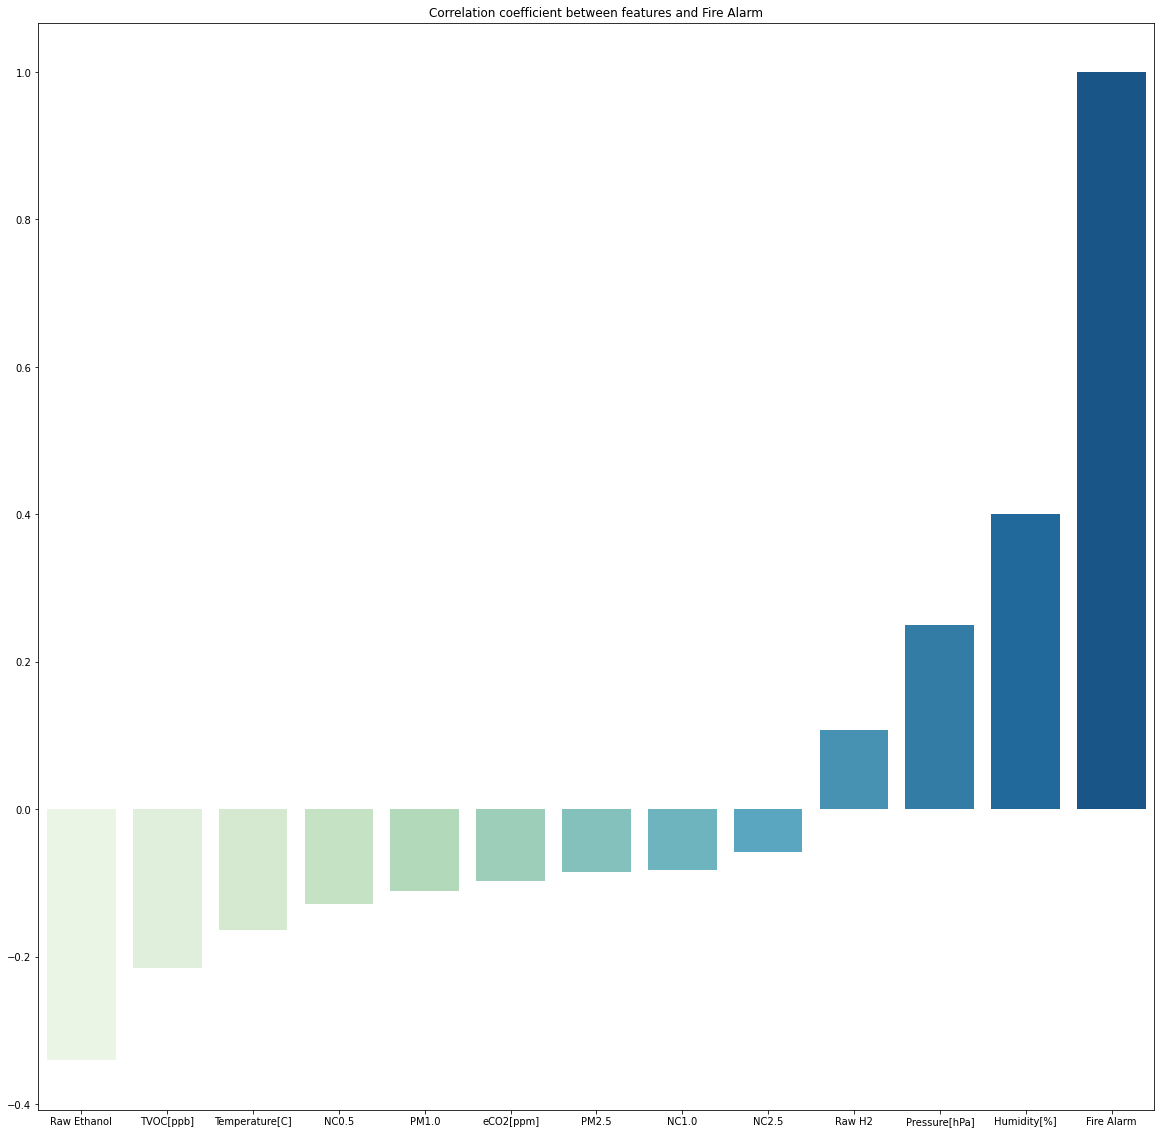

In [14]:
corr_coefs = df.corr()['Fire Alarm'].sort_values()
plt.figure(figsize=(20, 20))
plt.title("Correlation coefficient between features and Fire Alarm")
sns.barplot(x=corr_coefs.index.values.tolist(), y=corr_coefs.values.tolist(), palette='GnBu')

<a id='section44'></a>
### Conclusion
#### Based on the observation (not grouped and grouped by output) of mean and STD, I found that TVOC\[ppb\], eCO2[ppm], Raw H2, Raw Ethanol, PMs, and NCs may affect output a lot which means they maybe the important features.  
#### There are strong correlations between PMs and NCs.
#### Since these values are too large, they need to be normalized to range(0, 1).

<a id='section5'></a>
## Data Preprocess

### Normalization
#### Perform min-max normalization

In [15]:
df = (df - np.min(df)) / (np.max(df) - np.min(df))

<a id='section51'></a>
### Split dataset  
#### Train: 80%, Test: 20%

In [16]:
X = df.copy().drop('Fire Alarm', axis=1)
Y = df.copy()['Fire Alarm']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

Train size: 50104
Test size: 12526


([<matplotlib.patches.Wedge at 0x2bef55e5160>,
 [Text(-0.6905429676223556, 0.8562420276226288, '0'),
  Text(0.6905429676223558, -0.8562420276226286, '1')],
 [Text(-0.3766598005212848, 0.4670411059759793, '71.6%'),
  Text(0.37665980052128495, -0.46704110597597914, '28.4%')])

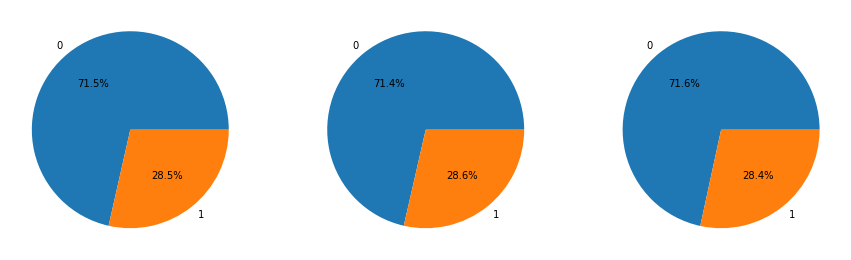

In [17]:
# Check size and distribution
print(f"Train size: {X_train.shape[0]}\nTest size: {X_test.shape[0]}")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].pie(df['Fire Alarm'].value_counts(), labels=[0, 1], autopct='%1.1f%%')
ax[1].pie(Y_train.value_counts(), labels=[0, 1], autopct='%1.1f%%')
ax[2].pie(Y_test.value_counts(), labels=[0, 1], autopct='%1.1f%%')

In [18]:
# Extract values
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

<a id='section6'></a>
## Model

<a id='section61'></a>
### Implementation

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [20]:
# Binary Cross-Entropy Loss
def BCELoss(a, y):
    term_0 = y * np.log(a + 1e-8)
    term_1 = (1 - y) * np.log(1 - a + 1e-8)
    if not isinstance(y, np.ndarray):
        n = 1
    else:
        n = y.shape[0]
    return -(np.sum(term_0 + term_1) / n)

In [21]:
def gradient_descent(x, y, a, w, b):
    if not isinstance(y, np.ndarray):
        n = 1
    else:
        n = y.shape[0]
    dw = np.dot(x.T, (a - y).T) / n
    db = np.sum(a - y) / n
    return dw, db

In [22]:
class Adam:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.lr = lr
    
    def update(self, t, w, b, dw, db):
        # Momentum
        self.m_dw = self.beta1 * self.m_dw + (1 - self.beta1) * dw
        self.m_db = self.beta1 * self.m_db + (1 - self.beta1) * db
        
        # Velocity
        self.v_dw = self.beta2 * self.v_dw + (1 - self.beta2) * (dw ** 2)
        self.v_db = self.beta2 * self.v_db + (1 - self.beta2) * (db ** 2)
        
        # Bias correction
        corrected_m_dw = self.m_dw / (1 - self.beta1)
        corrected_m_db = self.m_db / (1 - self.beta1)
        corrected_v_dw = self.v_dw / (1 - (self.beta2 ** 2))
        corrected_v_db = self.v_db / (1 - (self.beta2 ** 2))
        
        # Update
        w = w - self.lr * (corrected_m_dw / (np.sqrt(corrected_v_dw) + self.eps))
        b = b - self.lr * (corrected_m_db / (np.sqrt(corrected_v_db) + self.eps))
        
        return w, b

In [23]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.v_dw, self.v_db = 0, 0
        self.momentum = momentum
        self.lr = lr
    
    def update(self, t, w, b, dw, db):
        # Velocity
        self.v_dw = self.momentum * self.v_dw + self.lr * dw
        self.v_db = self.momentum * self.v_db + self.lr * db
        
        # Update
        w = w - self.v_dw
        b = b - self.v_db
        
        return w, b

In [24]:
def logistic_regression(X, Y, lr=0.01, epoch=10000, eps=0.0001, gradient_descent_method='BGD', optimizer=None, print_loss=True):
    # Initialize weights and bias
    w = np.zeros((X_train.shape[1], 1))
    b = 0
    
    # Initialize optimizer
    adam = Adam(lr=lr)
    momentum = Momentum(lr=lr)
    
    # Initialize index for SGD
    shuffled_idx = np.arange(0, X_train.shape[0])
    
    # Training Start
    global_loss = []
    for cur_epoch in range(epoch):
        # Batch Gradient Descent
        if gradient_descent_method == "BGD":
            # Predict
            A = sigmoid(np.dot(w.T, X.T) + b)

            # Calculate loss
            loss = BCELoss(A, Y)

            # Gradient descent
            dw, db = gradient_descent(X, Y, A, w, b)
            if optimizer == 'Momentum':
                    w, b = momentum.update(cur_epoch, w, b, dw, db)
            elif optimizer == 'Adam':
                w, b = adam.update(cur_epoch, w, b, dw, db)
            else:
                w = w - lr * dw
                b = b - lr * db
            
            if loss <= eps:
                break
        # Stochastic Gradient Descent
        if gradient_descent_method == "SGD":
            loss = []
            np.random.shuffle(shuffled_idx)
            for t, idx in enumerate(shuffled_idx):
                # Get data point
                x = X[idx].reshape(1, -1)
                y = Y[idx]
                
                # Predict
                a = sigmoid(np.dot(w.T, x.T) + b)
                
                # Calculate loss
                local_loss = BCELoss(a, y)
                
                # Gradient descent
                dw, db = gradient_descent(x, y, a, w, b)
                w = w - lr * dw
                b = b - lr * db
                
                loss.append(local_loss)
                if local_loss <= eps:
                    break
            loss = np.mean(loss)
        
        # Record loss for visualization and debug
        global_loss.append(loss)
        if cur_epoch % 500 == 0 and print_loss:
            print(f"Epoch {cur_epoch}, loss: {loss}")
    return w, b, global_loss

In [25]:
def predict(X, w, b):
    pred = sigmoid(np.dot(w.T, X.T) + b).reshape(-1)
    pred_score = pred.copy()
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0
    return pred, pred_score

In [26]:
def plot_loss(global_loss, title, ax):
    ax.plot(global_loss)
    ax.title.set_text(title)

<a id='section62'></a>
### Prediction

In [27]:
accuracies = {}
f1_scores = {}
ap_scores = {}
roc_auc_scores = {}

<a id='section621'></a>
#### Batch Gradient Descent

In [28]:
w, b, BGD_loss = logistic_regression(X_train, Y_train, epoch=10000, eps=0.0001, gradient_descent_method='BGD', print_loss=False)
Y_pred, Y_score = predict(X_test, w, b)
accuracies['BGD'] = metrics.accuracy_score(Y_test, Y_pred)
f1_scores['BGD'] = metrics.f1_score(Y_test, Y_pred)
ap_scores['BGD'] = metrics.average_precision_score(Y_test, Y_score)
roc_auc_scores['BGD'] = metrics.roc_auc_score(Y_test, Y_score)
print(f"Accuracy: {accuracies['BGD']}\nF1-score: {f1_scores['BGD']}\nAP-score: {ap_scores['BGD']}\nROCAUC-score: {roc_auc_scores['BGD']}")

Accuracy: 0.7383043269998403
F1-score: 0.842403846153846
AP-score: 0.8946364614070481
ROCAUC-score: 0.8021815246988401


<a id='section622'></a>
### Stochastic Gradient Descent

In [29]:
w, b, SGD_loss = logistic_regression(X_train, Y_train, epoch=10000, eps=0.001, gradient_descent_method='SGD', print_loss=False)
Y_pred, Y_score = predict(X_test, w, b)
accuracies['SGD'] = metrics.accuracy_score(Y_test, Y_pred)
f1_scores['SGD'] = metrics.f1_score(Y_test, Y_pred)
ap_scores['SGD'] = metrics.average_precision_score(Y_test, Y_score)
roc_auc_scores['SGD'] = metrics.roc_auc_score(Y_test, Y_score)
print(f"Accuracy: {accuracies['SGD']}\nF1-score: {f1_scores['SGD']}\nAP-score: {ap_scores['SGD']}\nROCAUC-score: {roc_auc_scores['SGD']}")

Accuracy: 0.8872744691042631
F1-score: 0.9245565291729002
AP-score: 0.960720692731486
ROCAUC-score: 0.9504081045344924


<a id='section623'></a>
#### Batch Gradient Descent with momentum

In [30]:
w, b, BGD_momentum_loss = logistic_regression(X_train, Y_train, epoch=10000, eps=0.001, gradient_descent_method='BGD', optimizer='Momentum', print_loss=False)
Y_pred, Y_score = predict(X_test, w, b)
accuracies['BGD_momentum'] = metrics.accuracy_score(Y_test, Y_pred)
f1_scores['BGD_momentum'] = metrics.f1_score(Y_test, Y_pred)
ap_scores['BGD_momentum'] = metrics.average_precision_score(Y_test, Y_score)
roc_auc_scores['BGD_momentum'] = metrics.roc_auc_score(Y_test, Y_score)
print(f"Accuracy: {accuracies['BGD_momentum']}\nF1-score: {f1_scores['BGD_momentum']}\nAP-score: {ap_scores['BGD_momentum']}\nROCAUC-score: {roc_auc_scores['BGD_momentum']}")

Accuracy: 0.8725850231518442
F1-score: 0.9167883211678833
AP-score: 0.9512383405170575
ROCAUC-score: 0.91182717794115


<a id='section624'></a>
#### Batch Gradient Descent with Adam

In [31]:
w, b, BGD_adam_loss = logistic_regression(X_train, Y_train, epoch=10000, eps=0.001, gradient_descent_method='BGD', optimizer='Adam', print_loss=False)
Y_pred, Y_score = predict(X_test, w, b)
accuracies['BGD_adam'] = metrics.accuracy_score(Y_test, Y_pred)
f1_scores['BGD_adam'] = metrics.f1_score(Y_test, Y_pred)
ap_scores['BGD_adam'] = metrics.average_precision_score(Y_test, Y_score)
roc_auc_scores['BGD_adam'] = metrics.roc_auc_score(Y_test, Y_score)
print(f"Accuracy: {accuracies['BGD_adam']}\nF1-score: {f1_scores['BGD_adam']}\nAP-score: {ap_scores['BGD_adam']}\nROCAUC-score: {roc_auc_scores['BGD_adam']}")

Accuracy: 0.8916653361009101
F1-score: 0.9278536870647031
AP-score: 0.968346423222561
ROCAUC-score: 0.956710636671786


<a id='section7'></a>
## Analyze Result
### Experiment Configs:
* Batch Gradient Descent
  - Learning Rate: 0.01
  - Acceptance thresholds: 0.0001
  - Epoch: 10000
  - Optimizer: None  
* Stochastic Gradient Descent
  - Learning Rate: 0.01
  - Acceptance thresholds: 0.0001
  - Epoch: 10000
  - Optimizer: None  
* Batch Gradient Descent with momentum
  - Learning Rate: 0.01
  - Acceptance thresholds: 0.0001
  - Epoch: 10000
  - Optimizer: Momentum  
* Batch Gradient Descent with adam
  - Learning Rate: 0.01
  - Acceptance thresholds: 0.0001
  - Epoch: 10000
  - Optimizer: Adam  

<a id='section71'></a>
### Visualizations

<a id='section711'></a>
#### Loss Visualizations

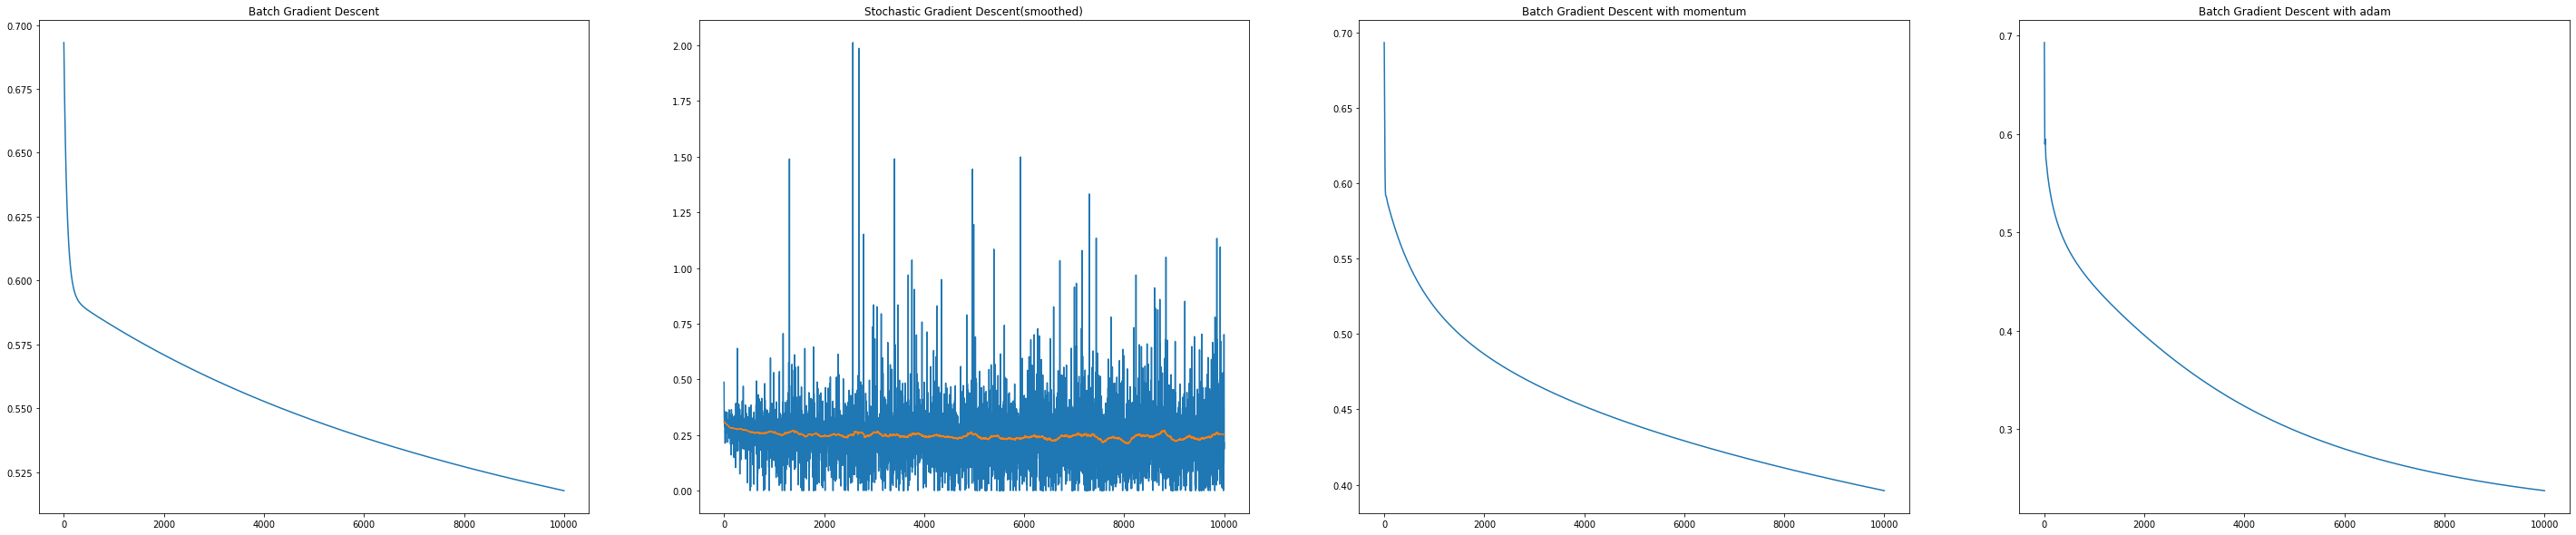

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(50, 10))
plot_loss(BGD_loss, 'Batch Gradient Descent', ax[0])
plot_loss(SGD_loss, 'Stochastic Gradient Descent(with smoothed)', ax[1])
plot_loss(savgol_filter(SGD_loss, 200, 1), 'Stochastic Gradient Descent(smoothed)', ax[1])
plot_loss(BGD_momentum_loss, 'Batch Gradient Descent with momentum', ax[2])
plot_loss(BGD_adam_loss, 'Batch Gradient Descent with adam', ax[3])

<a id='section712'></a>
#### Metrics Comparison Visualization

<AxesSubplot:>

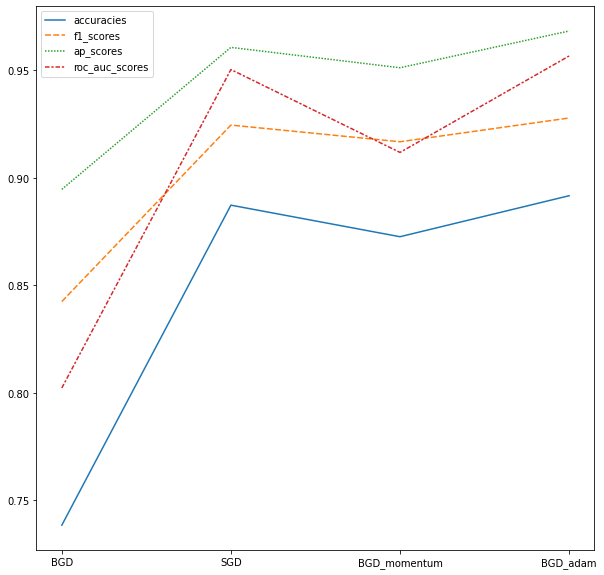

In [33]:
metrics_df = pd.concat((pd.DataFrame({"accuracies": accuracies}).T, pd.DataFrame({"f1_scores": f1_scores}).T, pd.DataFrame({"ap_scores": ap_scores}).T, pd.DataFrame({"roc_auc_scores": roc_auc_scores}).T)).reindex(columns=["BGD", "SGD", "BGD_momentum", "BGD_adam", "BGD_adam_100k"]).T
plt.figure(figsize=(10, 10))
sns.lineplot(metrics_df)

<a id='section72'></a>
### Conclusion
#### As expected, Batch Gradient Descent has the worst performance (but also a large improvemenet space) due to the large dataset. Stochastic Gradient Descent quickly converges and starts oscillating around the optimal values. The accuracy of Batch Gradient Descent with momentum is 1.5% worse than Stochastic Gradient Descent but its ability to correctly distinguish positive and negative samples(ROCAUC_score) are 3.9% worse than Stochastic Gradient Descent. Batch Gradient Descent with adam is slightly better than SGD and has the best performance. Generally, since this task has too many data (40000 in the train set), optimizer is always a powerful help in terms of improving the performance of and making it converges faster.